# Introduction
In this project im going to analyze and visualize the important informations about our dataset that'd be significant to create and train AI model that could predict sentiment based on given sentence.<br>
After that I will compare different methods and algorithms to see which one gives the best results.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [44]:
df = pd.read_csv('./twitter.csv', index_col=0)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
Index: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 9.5+ MB


,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...
416804,i feel like telling these horny devils to find...,2
416805,i began to realize that when i was feeling agi...,3
416806,i feel very curious be why previous early dawn...,5
416807,i feel that becuase of the tyranical nature of...,3


As far as we can see the file contains a lot of posts from Twitter with the rough amount of 390k rows which looks already preprocessed.<br>Let's check the balance of the labels.

Mean: 19.211015117235952
Harmonic mean: 13.34415792896653


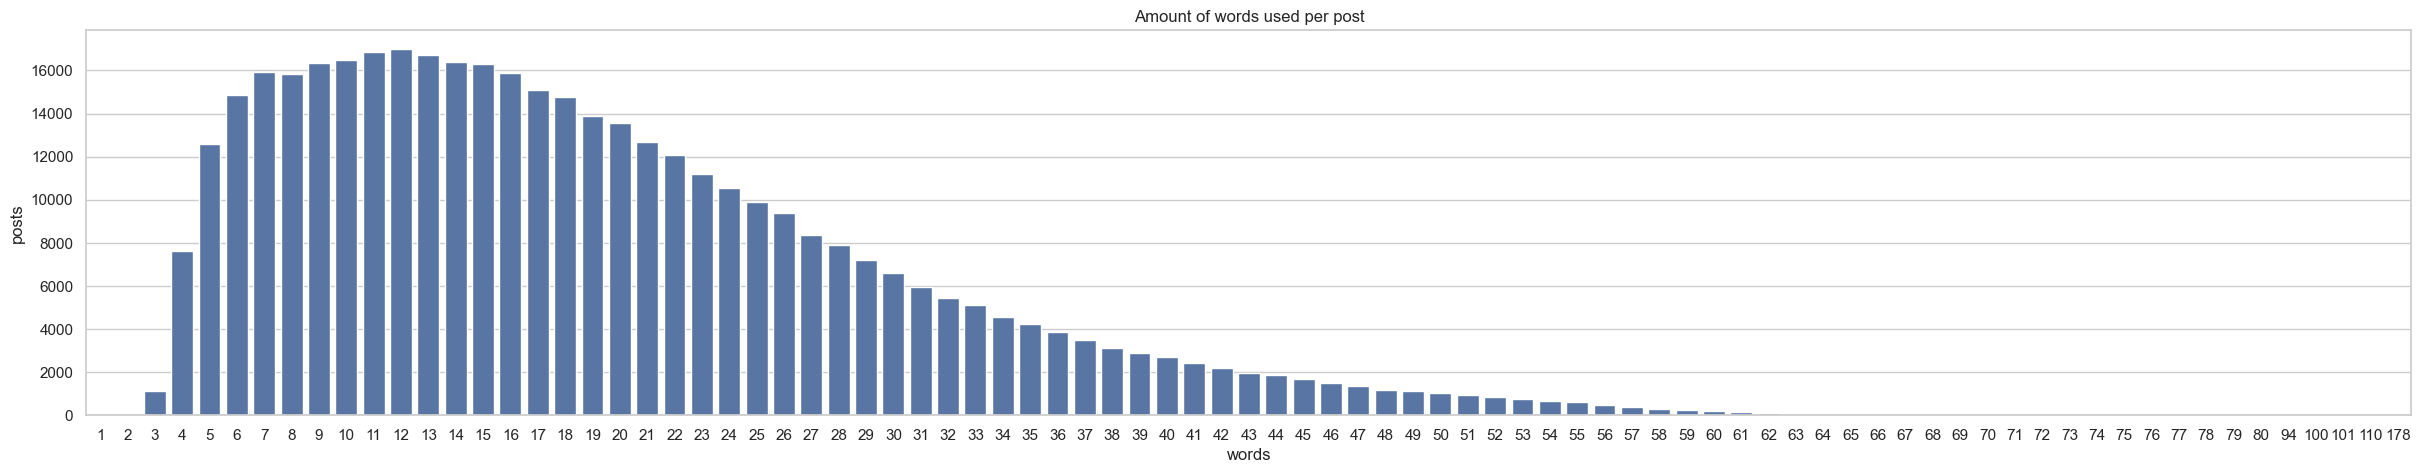

In [50]:
from scipy.stats import hmean

df['length'] = df['text'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(30, 5))
sns.countplot(df, x='length', ax=axes)
plt.title('Amount of words used per post')
plt.xlabel('words')
plt.ylabel('posts')

print(f"Mean: {df['length'].mean()}\n"
      f"Harmonic mean: {hmean(df['length'])}")

Text(0.5, 0, 'sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5)')

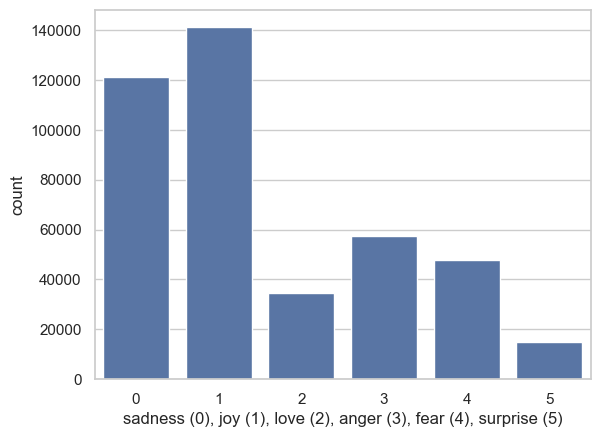

In [51]:
sns.countplot(df, x='label')
plt.xlabel('sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5)')

The balance between each label seems pretty incohesive especially if we look at the first two columns who stand out of the rest.<br><br>
By undersampling classes we get rid of unbalanced data problem by the cost of less data for training the model.<br>Later we'll see how it affected our score...

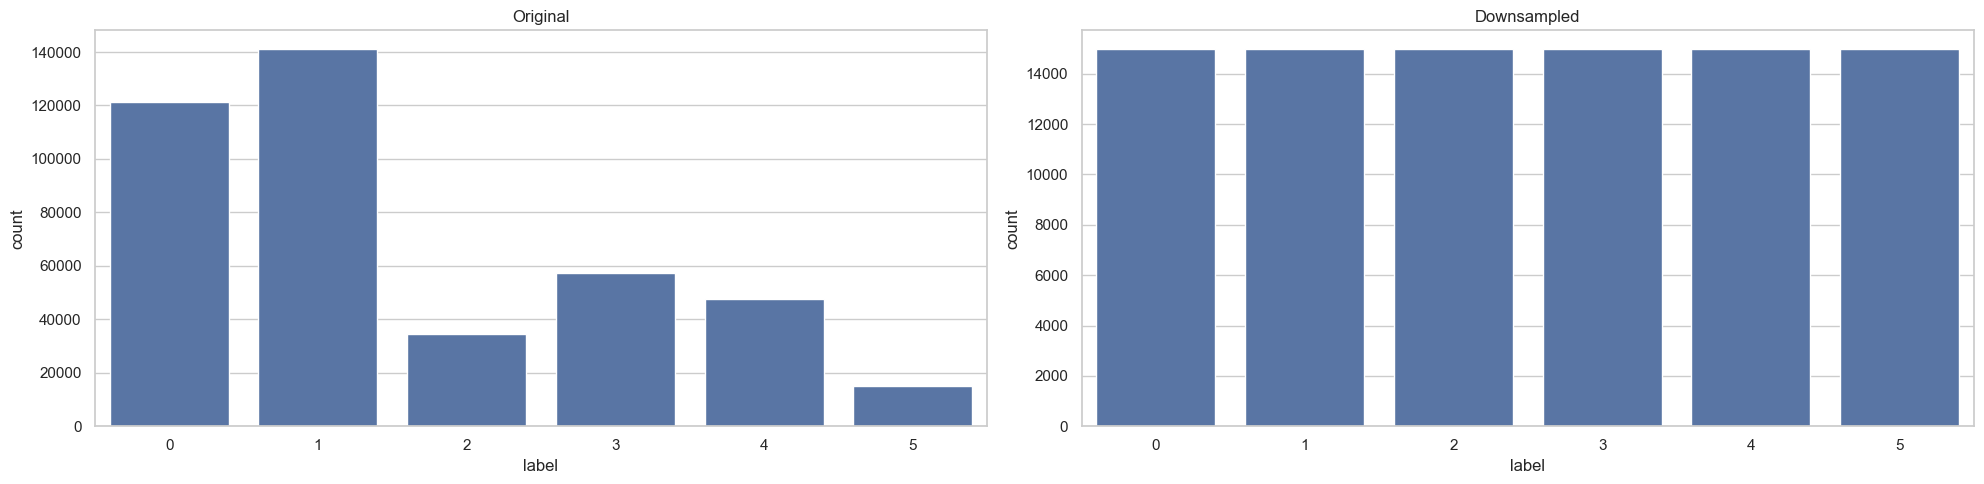

In [52]:
from sklearn.utils import resample

labeled = lambda i: df[df['label'] == i]
downsampled_df = pd.DataFrame(data=labeled(5))

for i in range(5):
      downsampled_class = resample(labeled(i),
                                   replace=False,
                                   n_samples=len(labeled(5)),
                                   random_state=42)
      downsampled_df = pd.concat([downsampled_df, downsampled_class])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
unbalanced = sns.countplot(df, x='label', ax=axes[0])
unbalanced.set_title('Original')
balanced = sns.countplot(downsampled_df, x='label', ax=axes[1])
balanced.set_title('Downsampled')
plt.tight_layout()

#### Creating the model
I've tried few algorithms such like: NaiveBayes, LinearRegression, etc.<br>
It turns out that SGDClassifier works the best.<br><br>
I've used 'Pipeline' because it's bery comfortable with hypertuning our parameters by using 'GridSearchCV'

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# FIRST MODEL WITH UNBALANCED DATA
x = df.iloc[:, 0]
y = df.iloc[:, 1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = Pipeline([
    ('vec', CountVectorizer(ngram_range=(1,2), stop_words='english')),
    #('tfid', TfidfVectorizer()),
    #('clf', ComplementNB())
    ('classifier', SGDClassifier(loss='huber', penalty='elasticnet', shuffle=False, random_state=42,
                          n_jobs=-1, epsilon=1, learning_rate='adaptive', eta0=0.5, alpha=0.0001))
])

model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# SECOND MODEL WITH BALANCED DATA
x_2 = downsampled_df.iloc[:, 0]
y_2 = downsampled_df.iloc[:, 1]
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_2, y_2, test_size=0.2, random_state=42)

#copying existing model beacause it's basically the same but with different data
model_downsampled = model

model_downsampled.fit(x_train_2, y_train_2)
y_pred_2 = model.predict(x_test_2)

Original:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     24201
           1       0.90      0.95      0.92     28164
           2       0.86      0.76      0.81      6929
           3       0.93      0.91      0.92     11441
           4       0.89      0.86      0.88      9594
           5       0.82      0.73      0.77      3033

    accuracy                           0.91     83362
   macro avg       0.89      0.86      0.87     83362
weighted avg       0.91      0.91      0.91     83362


Downsampled:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      2961
           1       0.94      0.88      0.91      3115
           2       0.91      0.99      0.95      2981
           3       0.96      0.93      0.94      3094
           4       0.92      0.87      0.90      2836
           5       0.90      0.99      0.94      2980

    accuracy                           0.93     17967

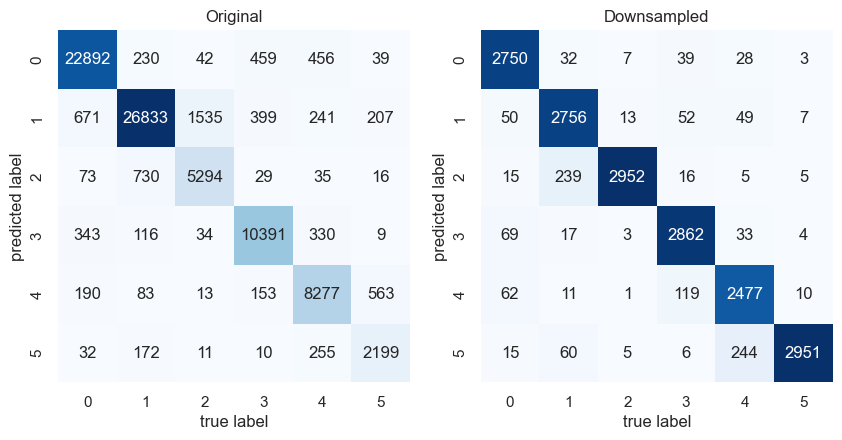

In [54]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.metrics import check_scoring

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

mat_orgiginal = confusion_matrix(y_test, y_pred)
sns.heatmap(mat_orgiginal.T, annot=True, fmt='d', square=True, cbar=False, cmap='Blues', ax=axes[0])

mat_downsampled = confusion_matrix(y_test_2, y_pred_2)
sns.heatmap(mat_downsampled.T, annot=True, fmt='d', square=True, cbar=False, cmap='Blues', ax=axes[1])

axes[0].set_title('Original')
axes[1].set_title('Downsampled')

for i in range(2):
    axes[i].set_xlabel('true label')
    axes[i].set_ylabel('predicted label')
    
print(f"Original:\n{classification_report(y_test, y_pred)}\n")
print(f"Downsampled:\n{classification_report(y_test_2, y_pred_2)}")


Hypertuning leftovers

In [ ]:
from sklearn.model_selection import GridSearchCV
parameters = {
    #'clf__n_estimators': [50, 100, 200],
    #'clf__learning_rate': [0.1, 0.5, 1.0],
    #'clf__estimator__alpha': [0.001, 0.001, 0.01]
    'clf__alpha': [n/100_000 for n in range(5, 15)]
    #'clf__loss': ['hinge', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    #'clf__loss': ['hinge', 'squared_hinge'],
    #'clf__penalty': ['elasticnet', 'l1', 'l2', None],
    #'clf__epsilon': [n/10 for n in range(11)],
    #'clf__learning_rate': ['constant', 'optimal', 'adaptive', 'invscaling'],
    #'clf__eta0': [n/100 for n in range(1, 101, 10)]
}
gf_clf = GridSearchCV(model, parameters, cv=5, n_jobs=-1, verbose=1)
gs_clf = gf_clf.fit(x_train, y_train)

print(gs_clf.best_score_)
print(gs_clf.best_params_)